#CS6910 Assignment-1
- Submitted by Dhananjay Balakrishnan, ME19B012

#Question 1: Loading and Visualizing the Fashion_MNIST Dataset

In [1]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import wandb

In [3]:
!wandb login

wandb: Currently logged in as: dhananjayb (clroymustang). Use `wandb login --relogin` to force relogin


In [4]:
entity_name = "clroymustang"
project_name = "cs6910-assignment-1"

In [5]:
labels_fashion_mnist = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist

In [7]:
(trainX, trainy), (testX, testy) = fashion_mnist.load_data()

In [ ]:
wandb.init(entity=entity_name,project=project_name, name="q1_run_again")
completed_labels = []
images = []

for (image, label) in zip(trainX, trainy):
  if len(completed_labels) == 10:
    break

  if label in completed_labels:
    continue
  else:
    completed_labels.append(label)
    images.append(wandb.Image(image, caption = labels_fashion_mnist[label]))

wandb.log({"sample_images":images})
wandb.finish()

#Questions 2 and 3: The Neural Network and the training loop

In [8]:
import numpy as np
from sklearn.metrics import accuracy_score
import cv2
import copy 

class NeuralNetwork:
    def __init__(self, n_hidden = 3, hl_size = 128, batch_size = 32, weight_init = 'Xavier', activation_fn = 'tanh', \
                 optimizer = 'nadam', lr = 0.001, n_input = 28*28, n_output = 10, loss_type = 'cross_entropy', lamda = 0.0005, \
                 m_factor = 0.9, beta = 0.9, epsilon = 0.000001, beta1 = 0.9, beta2 = 0.99):
        self.n_hidden = n_hidden #number of hidden layers
        self.hl_size = hl_size #size of each hidden layer
        self.batch_size = batch_size 
        self.activation_fn = activation_fn
        self.lr = lr
        self.weight_init = weight_init
        self.n_input = n_input
        self.n_output = n_output
        self.optimizer = optimizer
        self.loss_type = loss_type
        self.lamda = lamda
        self.m_factor = m_factor
        self.beta = beta
        self.epsilon = epsilon
        self.beta1 = beta1
        self.beta2 = beta2
        #self.long_wandb = log_wandb

        self.weights = []
        self.biases = []
        
        self.a_list = []
        self.h_list = []
        self.weight_gradients = []
        self.bias_gradients = []
        self.weight_updates = []
        self.bias_updates = []
        self.loss = 0

        self.weight_history = []
        self.bias_history = []
        self.rmsprop_weight = []
        self.rmsprop_bias = []

        self.adam_weight = []
        self.adam_bias = []
        self.adam_iter = 1

        self.layer_sizes = [n_input]
        for i in range(n_hidden):
          self.layer_sizes.append(hl_size)
        self.layer_sizes.append(n_output)
        self.init_weights()

    def init_weights(self):
        if self.weight_init == 'Xavier':
          for i in range(0,len(self.layer_sizes)-1):
            a = np.sqrt(6/(self.layer_sizes[i] + self.layer_sizes[i+1]))
            w_arr = np.random.uniform(low = -a, high = a, size = (self.layer_sizes[i], self.layer_sizes[i+1]))
            self.weights.append(w_arr)
            b_arr = np.zeros((self.layer_sizes[i+1], 1))
            self.biases.append(b_arr)
        
        elif self.weight_init == 'random':
          for i in range(0,len(self.layer_sizes)-1):
            w_arr = 0.01*np.random.randn(self.layer_sizes[i], self.layer_sizes[i+1])
            self.weights.append(w_arr)
            b_arr = 0.01*np.random.randn(self.layer_sizes[i+1], 1)
            self.biases.append(b_arr)

        else:
            print('Choose correct initialization.')
            quit()
    
    def activation(self, a):
        if self.activation_fn == 'sigmoid':
          return (1.0/(1.0+np.exp(-a)))
        elif self.activation_fn == 'tanh':
          return np.tanh(a)
        elif self.activation_fn == 'identity':
          return a
        else:
          return np.maximum(0,a)
    
    def calculate_grad(self, a):
        if self.activation_fn == 'sigmoid':
            return self.activation(a)*(1-self.activation(a))
        elif self.activation_fn == 'tanh':
            return 1.0 - self.activation(a)**2
        elif self.activation_fn == 'identity':
            return 1
        else:
            return 1*(a > 0)
    
    def softmax_grad(self, a):
      return self.softmax(a)*(1-self.softmax(a))
    
    def loss_fn(self, predicted, labels):
      error = 0
      if self.loss_type == 'cross_entropy':
        #labels are one-hot encoded.
        error = error - np.log(predicted[np.argmax(labels)])
        error = error[0]
      else:
        error = error + 0.5*np.mean((predicted - labels)**2)
      
      
      for i in range(0, len(self.weights)):
        reg_error = np.sum(self.weights[i]*self.weights[i])
        error = error + self.lamda*reg_error
      
      
      return error

    def softmax(self, output):
        out = [np.exp(x) for x in output]
        out = out/np.sum((out))
        return out
      
    def feedforward(self, x):
        self.activated_layers = []
        output = copy.deepcopy(x)
        
        self.a_list = [output]
        self.h_list = [output]

        for i in range(0, self.n_hidden):
            output = np.transpose(self.weights[i])@output.reshape(-1,1) + self.biases[i]
            self.a_list.append(output)
            output = self.activation(output)
            self.h_list.append(output)
        
        output = np.transpose(self.weights[-1])@output + self.biases[-1]
        output = self.softmax(output)
        return output
    
    def backprop(self, y_pred, y_true):
        self.weight_gradients = []
        self.bias_gradients = []

        if self.loss_fn == 'cross_entropy':
          grad_a = y_pred - y_true.reshape(-1, 1) 
        else:
          grad_a = np.multiply(y_pred - y_true.reshape(-1, 1), 1 - y_pred**2)
        #dimensions: (n_out x 1)
        for i in range(1,self.n_hidden + 2):
          grad_w = np.dot(self.h_list[-i].reshape(-1,1), np.transpose(grad_a))
          grad_b = copy.deepcopy(grad_a)
          self.weight_gradients.append(grad_w)
          self.bias_gradients.append(grad_b)
          grad_h_prev = np.dot(self.weights[-i], grad_a)
          derivative = self.calculate_grad(self.a_list[-i])
          grad_a = np.multiply(grad_h_prev, derivative)

        self.weight_gradients.reverse()
        self.bias_gradients.reverse()
    
    def batchwise_gradient(self, X, y, look_forward = False):
      self.weight_updates = []
      self.bias_updates = []
      for i in range(0, len(X)):
        y_pred = self.feedforward(X[i])
        self.backprop(y_pred, y[i])
        if look_forward == False:
          if self.loss_type=='cross_entropy':
            self.loss = self.loss + self.loss_fn(y_pred, y[i].reshape(-1, 1))
          else:
            self.loss = self.loss + self.loss_fn(y_pred, y[i])
        if i==0:
          self.weight_updates = copy.deepcopy(self.weight_gradients)
          self.bias_updates = copy.deepcopy(self.bias_gradients)
        else:
          for i in range(0, len(self.weight_gradients)):
            self.weight_updates[i] = self.weight_updates[i] + self.weight_gradients[i]
            self.bias_updates[i] = self.bias_updates[i] + self.bias_gradients[i]
      
    def step(self, X, y):
      self.batchwise_gradient(X, y)
      reg_factor = (1 - ((self.lr*self.lamda)/self.batch_size))
      if self.optimizer == 'sgd':
        for i in range(0, len(self.weights)):
          self.weights[i] = reg_factor*self.weights[i] - self.lr*self.weight_updates[i]
          self.biases[i] = self.biases[i] - self.lr*self.bias_updates[i]
      
      elif self.optimizer == 'momentum':
        if len(self.weight_history) == 0:
          self.weight_history = copy.deepcopy(self.weight_updates)
          self.bias_history = copy.deepcopy(self.bias_updates)
        else:
          for i in range(0, len(self.weight_history)):
            self.weight_history[i] = self.m_factor*self.weight_history[i] + self.weight_updates[i]
            self.bias_history[i] = self.m_factor*self.bias_history[i] + self.bias_updates[i]
        
        for i in range(0, len(self.weights)):
          self.weights[i] = reg_factor*self.weights[i] - self.lr*self.weight_history[i]
          self.biases[i] = self.biases[i] - self.lr*self.bias_history[i]

      elif self.optimizer == 'nesterov':
        temp_weights = copy.deepcopy(self.weights)
        temp_biases = copy.deepcopy(self.biases)
        
        if len(self.weight_history) == 0:
          self.weight_history = [self.lr*weight for weight in self.weight_updates]
          self.bias_history = [self.lr*bias for bias in self.bias_updates]
        else:
          for i in range(0, len(self.weight_history)):
            self.weights[i] = self.weights[i] - self.m_factor*self.weight_history[i]
            self.biases[i] = self.biases[i] - self.m_factor*self.bias_history[i]

          self.batchwise_gradient(X, y, look_forward = True)

          for i in range(0, len(self.weight_history)):
            self.weight_history[i] = self.m_factor*self.weight_history[i] + self.lr*self.weight_updates[i]
            self.bias_history[i] = self.m_factor*self.bias_history[i] + self.lr*self.bias_updates[i]
        
          self.weights = copy.deepcopy(temp_weights)
          self.biases = copy.deepcopy(temp_biases)
        
        for i in range(0, len(self.weights)):
          self.weights[i] = reg_factor*self.weights[i] - self.weight_history[i]
          self.biases[i] = self.biases[i] - self.bias_history[i]
      
      elif self.optimizer == 'rmsprop':
        if len(self.rmsprop_weight) == 0:
          self.rmsprop_weight = [grad**2 for grad in self.weight_updates]
          self.rmsprop_bias = [grad**2 for grad in self.bias_updates]
        else:
          for i in range(0, len(self.rmsprop_weight)):
            self.rmsprop_weight[i] = self.beta*self.rmsprop_weight[i] + (1-self.beta)*self.weight_updates[i]**2
            self.rmsprop_bias[i] = self.beta*self.rmsprop_bias[i] + (1-self.beta)*self.bias_updates[i]**2
        
        for i in range(0, len(self.weights)):
          self.weights[i] = reg_factor*self.weights[i] - self.lr*(self.weight_updates[i]/(np.sqrt(self.rmsprop_weight[i] + self.epsilon)))
          self.biases[i] = self.biases[i] - self.lr*(self.bias_updates[i]/(np.sqrt(self.rmsprop_bias[i] + self.epsilon)))
      
      elif self.optimizer == 'adam':
        if len(self.weight_history) == 0:
          self.weight_history = [(1-self.beta1)*grad for grad in self.weight_updates]
          self.bias_history = [(1-self.beta1)*grad for grad in self.bias_updates]
          self.adam_weight = [(1-self.beta2)*grad**2 for grad in self.weight_updates]
          self.adam_bias = [(1-self.beta2)*grad**2 for grad in self.bias_updates]
        else:
          for i in range(0, len(self.adam_weight)):
            self.weight_history[i] = self.beta1*self.weight_history[i] + (1 - self.beta1)*self.weight_updates[i]
            self.bias_history[i] = self.beta1*self.bias_history[i] + (1 - self.beta1)*self.bias_updates[i]
            self.adam_weight[i] = self.beta2*self.adam_weight[i] + (1 - self.beta2)*self.weight_updates[i]**2
            self.adam_bias[i] =  self.beta2*self.adam_bias[i] + (1 - self.beta2)*self.bias_updates[i]**2
        
        self.adam_grad_weight = [grad/(1-((self.beta1)**self.adam_iter)) for grad in self.weight_history]
        self.adam_grad_bias = [grad/(1-((self.beta1)**self.adam_iter)) for grad in self.bias_history]

        self.adam_lr_weight = [update/(1-((self.beta2)**self.adam_iter)) for update in self.adam_weight]
        self.adam_lr_bias = [update/(1-((self.beta2)**self.adam_iter)) for update in self.adam_bias]

        for i in range(0, len(self.weights)):
          self.weights[i] = reg_factor*self.weights[i] - self.lr*(self.adam_grad_weight[i]/(np.sqrt(self.adam_lr_weight[i] + self.epsilon)))
          self.biases[i] = self.biases[i] - self.lr*(self.adam_grad_bias[i]/(np.sqrt(self.adam_lr_bias[i] + self.epsilon)))
        
        self.adam_iter = self.adam_iter + 1
      
      elif self.optimizer == 'nadam':
        if len(self.weight_history) == 0:
          self.weight_history = [(1-self.beta1)*grad for grad in self.weight_updates]
          self.bias_history = [(1-self.beta1)*grad for grad in self.bias_updates]
          self.adam_weight = [(1-self.beta2)*grad**2 for grad in self.weight_updates]
          self.adam_bias = [(1-self.beta2)*grad**2 for grad in self.bias_updates]
        else:
          for i in range(0, len(self.adam_weight)):
            self.weight_history[i] = self.beta1*self.weight_history[i] + (1 - self.beta1)*self.weight_updates[i]
            self.bias_history[i] = self.beta1*self.bias_history[i] + (1 - self.beta1)*self.bias_updates[i]
            self.adam_weight[i] = self.beta2*self.adam_weight[i] + (1 - self.beta2)*self.weight_updates[i]**2
            self.adam_bias[i] =  self.beta2*self.adam_bias[i] + (1 - self.beta2)*self.bias_updates[i]**2
        
        self.adam_grad_weight = [grad/(1-((self.beta1)**self.adam_iter)) for grad in self.weight_history]
        self.adam_grad_bias = [grad/(1-((self.beta1)**self.adam_iter)) for grad in self.bias_history]

        self.adam_lr_weight = [update/(1-((self.beta2)**self.adam_iter)) for update in self.adam_weight]
        self.adam_lr_bias = [update/(1-((self.beta2)**self.adam_iter)) for update in self.adam_bias]

        factor = (1 - self.beta1)/(1 - (self.beta1**self.adam_iter))

        for i in range(0, len(self.weights)):
          self.weights[i] = reg_factor*self.weights[i] - self.lr*((self.beta1*self.adam_grad_weight[i] + (factor*self.weight_updates[i]))/(np.sqrt(self.adam_lr_weight[i] + self.epsilon)))
          self.biases[i] = self.biases[i] - self.lr*((self.beta1*self.adam_grad_bias[i] + (factor*self.bias_updates[i]))/(np.sqrt(self.adam_lr_bias[i] + self.epsilon)))
        
        self.adam_iter = self.adam_iter + 1
      
      else:
        print('Error in optimizer name.')
      
    def reset(self):
      self.loss = 0
      self.weight_history = []
      self.bias_history = []
      self.rmsprop_weight = []
      self.rmsprop_bias = []
      self.adam_iter = 1
      self.adam_weight = []
      self.adam_bias = []

    
    def inference(self, x_test, y_test, loss_flag = True):
      if loss_flag:
        predictions = []
        loss = 0
        y_label = copy.deepcopy(y_test)

        for (x,y) in zip(x_test,y_test):
          pred = self.feedforward(x)
          loss = loss + self.loss_fn(pred, y)
          predictions.append(pred)
        
        y_pred = [np.argmax(predictions[i]) for i in range(0,len(predictions))]
        y_label = [np.argmax(y_test[i]) for i in range(0,len(y_test))]
              
        acc = accuracy_score(y_label, y_pred)

        return loss, acc

      else:
        predictions = []
        y_label = copy.deepcopy(y_test)

        for (x,y) in zip(x_test,y_test):
          pred = self.feedforward(x)
          predictions.append(pred)
        
        y_pred = [np.argmax(predictions[i]) for i in range(0,len(predictions))]
        y_label = [np.argmax(y_test[i]) for i in range(0,len(y_test))]
        
        acc = accuracy_score(y_label, y_pred)

        return acc
    
    def epoch(self, x_train, y_train, x_test, y_test, index):
      for i in range(0,len(x_train),self.batch_size):
        if i+self.batch_size < len(x_train):
          xbatch = x_train[i:i+self.batch_size]
          ybatch = y_train[i:i+self.batch_size]
        else:
          xbatch = x_train[i:]
          ybatch = y_train[i:]

        self.step(xbatch, ybatch)
        
  
      test_loss, test_acc = self.inference(x_test, y_test)
      train_acc = self.inference(x_train, y_train, loss_flag = False)
      train_loss = self.loss/len(x_train)
      test_loss = test_loss/len(x_test)
      print(f'Epoch {index+1} completed. Training Loss is {train_loss}, training accuracy is {train_acc}. The test loss is {test_loss} and the test accuracy is {test_acc}.')
      self.reset()
      return train_loss,train_acc,test_acc,test_loss

In [9]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split


network = NeuralNetwork(optimizer = 'nesterov', activation_fn = 'ReLU', batch_size = 64, hl_size = 128, weight_init = 'random', lamda = 0, lr = 0.0001, n_hidden = 3)
n_epochs = 10  


(trainX, trainy), (testX, testy) = fashion_mnist.load_data()

trainX = trainX/255
testX = testX/255

trainX, valX, trainy, valy = train_test_split(trainX, trainy, test_size=0.1, random_state=40)

#Add code to flatten images
x_train = []
x_test = []
x_val = []
for i in range(0, len(trainX)):
  x_train.append(trainX[i,:,:].flatten())
for i in range(0, len(testX)):
  x_test.append(testX[i,:,:].flatten())
for i in range(0, len(valX)):
  x_val.append(valX[i,:,:].flatten())

y_train = to_categorical(trainy)
y_test = to_categorical(testy)
y_val = to_categorical(valy)

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
print('Training process started with '+network.optimizer+' optimizer.')
for i in range(0, n_epochs):
    #loss = network.epoch(x_train, trainy_encoded, x_test, testy_encoded, i)
    train_loss,train_acc,test_acc,test_loss = network.epoch(x_train, y_train, x_val, y_val, i)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

#Question 4: Hyperparameter sweep, using wandb

In [ ]:
entity_name = "clroymustang"
project_name = "cs6910-assignment-1"

In [ ]:
def sweep():
  defaults = {
      'epochs': 5,
      'number_hidden_layers': 3,
      'hidden_layer_size': 32,
      'lamda': 0,
      'learning_rate': 0.001,
      'initialization_type': 'Xavier',
      'optimizer': 'sgd',
      'batch_size': 16,
      'activation_fn': 'sigmoid'
  }
  wandb.init(config = defaults)
  config = wandb.config

  network = NeuralNetwork(n_hidden = config.number_hidden_layers, hl_size = config.hidden_layer_size, weight_init = config.initialization_type, \
                          activation_fn = config.activation_fn, optimizer = config.optimizer, lr = config.learning_rate, lamda = config.lamda, batch_size = config.batch_size)
  n_epochs = config.epochs    

  for i in range(0, n_epochs):
      #loss = network.epoch(x_train, trainy_encoded, x_test, testy_encoded, i)
      train_loss,train_acc,test_acc,test_loss = network.epoch(x_train, y_train, x_val, y_val, i)
      log_dict = {"train_loss":train_loss, "train_accuracy":train_acc, "validation_loss":test_loss, "validation_accuracy":test_acc, "epoch":i+1}
      wandb.log(log_dict)
  
  sweep_name = str(config.epochs) + "_" + str(config.number_hidden_layers) + "_" + str(config.hidden_layer_size) + "_" + str(config.lamda) + "_" + \
  str(config.learning_rate) + "_" + config.initialization_type[0] + "_" + config.optimizer[0:2] + "_" + str(config.batch_size) + "_" + config.activation_fn
  wandb.run.name = sweep_name

  wandb.run.save()
  wandb.run.finish()

In [ ]:
hyperparameters = {
      "epochs": {
          'values': [5, 10]
      },
      "number_hidden_layers": {
          'values' : [3, 4, 5]
      },
      "hidden_layer_size": {
          'values' : [32, 64, 128]
      },
      "lamda": {
          'values': [0, 0.0005, 0.5]
      },
      "learning_rate":{
        'values': [0.001, 0.0001]
      },
      "initialization_type": {
          'values' : ['Xavier', 'random']
      },
      "optimizer": {
          'values': ['sgd', 'momentum', 'nesterov', 'rmsprop', 'adam', 'nadam']
      },
      "batch_size": {
          'values': [16, 32, 64]
      },
      "activation_fn": {
          'values': ['sigmoid','tanh','ReLU']
      }
  }

In [ ]:
sweep_configuration = {
    'method': 'bayes',
    'name': 'sweep',
    'metric': {
        'goal': 'maximize', 
        'name': 'validation_accuracy'
        },
    'parameters': hyperparameters
}

In [ ]:
#sweep_id = wandb.sweep(sweep_configuration, entity=entity_name, project=project_name)
sweep_id = 'ng51libu'

In [ ]:
wandb.agent(sweep_id, sweep, project = project_name)

wandb: Agent Starting Run: 53pgamgk with config:
wandb: 	activation_fn: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	initialization_type: random
wandb: 	lamda: 0.0005
wandb: 	learning_rate: 0.001
wandb: 	number_hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: Currently logged in as: dhananjayb (clroymustang). Use `wandb login --relogin` to force relogin


wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▆▆▇▇▇██
train_loss,█▆▄▂▁▁▁▁▁▁
validation_accuracy,▁▃▅▆▇▇▇▇██
validation_loss,█▄▃▂▁▁▁▁▁▁
epoch,10
train_accuracy,0.86302
train_loss,1.21804
validation_accuracy,0.851
validation_loss,1.23936


wandb: Agent Starting Run: k3vbsmn8 with config:
wandb: 	activation_fn: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	initialization_type: random
wandb: 	lamda: 0.0005
wandb: 	learning_rate: 0.001
wandb: 	number_hidden_layers: 3
wandb: 	optimizer: sgd


wandb: Ctrl + C detected. Stopping sweep.


#Question 7: Confusion Matrix for best configurations

In [10]:
import pickle
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

In [11]:
best_params_1 = {
  'n_hidden':3, 'hl_size': 128, 'batch_size':32, 'weight_init':'Xavier', 'activation_fn':'tanh', \
 'optimizer':'nadam', 'lamda':0.0005, 'lr':0.001
}

n_epoch_1 = 10

In [12]:
best_params_2 = {
  'n_hidden':5, 'hl_size': 128, 'batch_size':32, 'weight_init':'Xavier', 'activation_fn':'tanh', \
 'optimizer':'adam', 'lamda':0.5, 'lr':0.0001
}

n_epoch_2 = 9

In [13]:
best_params_3 = {
  'n_hidden':3, 'hl_size': 128, 'batch_size':64, 'weight_init':'Xavier', 'activation_fn':'ReLU', \
 'optimizer':'nadam', 'lamda':0.5, 'lr':0.001
}

n_epoch_3 = 4

In [ ]:
network1 = NeuralNetwork(**best_params_1)

print('Training process started with '+network1.optimizer+' optimizer.')
for i in range(0, n_epoch_1):
    #loss = network.epoch(x_train, trainy_encoded, x_test, testy_encoded, i)
    train_loss,train_acc,test_acc,test_loss = network1.epoch(x_train, y_train, x_val, y_val, i)

Training process started with nadam optimizer.
Epoch 1 completed. Training Loss is 0.7698900068745445, training accuracy is 0.8655185185185185. The test loss is 0.7710072002730421 and the test accuracy is 0.852.
Epoch 2 completed. Training Loss is 0.7985333316202926, training accuracy is 0.8816481481481482. The test loss is 0.8680540481152957 and the test accuracy is 0.8671666666666666.
Epoch 3 completed. Training Loss is 0.9012747847064005, training accuracy is 0.8919074074074074. The test loss is 0.9954321164831265 and the test accuracy is 0.8735.
Epoch 4 completed. Training Loss is 1.0221100823361338, training accuracy is 0.8962777777777777. The test loss is 1.1307276573704517 and the test accuracy is 0.8768333333333334.
Epoch 5 completed. Training Loss is 1.1514226127445846, training accuracy is 0.8995. The test loss is 1.2818578533002585 and the test accuracy is 0.8785.
Epoch 6 completed. Training Loss is 1.2840985482220728, training accuracy is 0.9041851851851852. The test loss i

In [ ]:
file_name = 'model1.pkl'
with open(file_name, 'wb') as file:
    pickle.dump(network1, file)
    print(f'Object successfully saved to "{file_name}"')

Object successfully saved to "model1.pkl"


In [ ]:
network2 = NeuralNetwork(**best_params_2)

print('Training process started with '+network2.optimizer+' optimizer.')
for i in range(0, n_epoch_2):
    #loss = network.epoch(x_train, trainy_encoded, x_test, testy_encoded, i)
    train_loss,train_acc,test_acc,test_loss = network2.epoch(x_train, y_train, x_val, y_val, i)

file_name = 'model2.pkl'
with open(file_name, 'wb') as file:
    pickle.dump(network2, file)
    print(f'Object successfully saved to "{file_name}"')

Training process started with adam optimizer.
Epoch 1 completed. Training Loss is 386.4706764989969, training accuracy is 0.8507037037037037. The test loss is 391.7977572619823 and the test accuracy is 0.8448333333333333.
Epoch 2 completed. Training Loss is 394.8275922100034, training accuracy is 0.8678333333333333. The test loss is 397.32710172225177 and the test accuracy is 0.8585.
Epoch 3 completed. Training Loss is 399.7543880516974, training accuracy is 0.8753333333333333. The test loss is 401.8819396635416 and the test accuracy is 0.864.
Epoch 4 completed. Training Loss is 404.0839130243086, training accuracy is 0.8812592592592593. The test loss is 406.0646000936023 and the test accuracy is 0.8698333333333333.
Epoch 5 completed. Training Loss is 408.1579393432675, training accuracy is 0.8864074074074074. The test loss is 410.07340872089804 and the test accuracy is 0.8745.
Epoch 6 completed. Training Loss is 412.11526231230795, training accuracy is 0.8901296296296296. The test los

In [ ]:
network3 = NeuralNetwork(**best_params_3)

print('Training process started with '+network3.optimizer+' optimizer.')
for i in range(0, n_epoch_3):
    #loss = network.epoch(x_train, trainy_encoded, x_test, testy_encoded, i)
    train_loss,train_acc,test_acc,test_loss = network3.epoch(x_train, y_train, x_val, y_val, i)

file_name = 'model3.pkl'
with open(file_name, 'wb') as file:
    pickle.dump(network3, file)
    print(f'Object successfully saved to "{file_name}"')

Training process started with nadam optimizer.
Epoch 1 completed. Training Loss is 286.34345438882485, training accuracy is 0.8702777777777778. The test loss is 313.48957692354674 and the test accuracy is 0.8586666666666667.
Epoch 2 completed. Training Loss is 343.25229965476245, training accuracy is 0.8854814814814815. The test loss is 370.4246792883727 and the test accuracy is 0.8713333333333333.
Epoch 3 completed. Training Loss is 399.9542791131284, training accuracy is 0.895462962962963. The test loss is 427.2923839935217 and the test accuracy is 0.8756666666666667.
Epoch 4 completed. Training Loss is 456.303359815393, training accuracy is 0.8996851851851851. The test loss is 483.66983029885836 and the test accuracy is 0.8811666666666667.
Object successfully saved to "model3.pkl"


Now, getting to the confusion matrix itself

In [ ]:
images = []

In [ ]:
with open('model1.pkl', 'rb') as f:
    model1 = pickle.load(f)

In [ ]:
predictions = []
for x in x_test:
  pred = model1.feedforward(x)
  predictions.append(pred)
        
y_pred = [np.argmax(predictions[i]) for i in range(0,len(predictions))]
y_label = [np.argmax(y_test[i]) for i in range(0,len(y_test))]

In [ ]:
print(accuracy_score(y_label, y_pred))

0.872


In [ ]:
cm = pd.DataFrame(confusion_matrix(y_label, y_pred), columns=labels_fashion_mnist, index = labels_fashion_mnist)

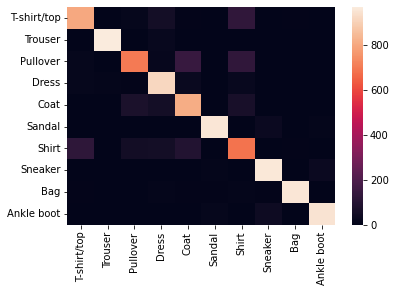

In [ ]:
image = sns.heatmap(cm)
images.append(wandb.Image(image, caption = 'Model 1'))

In [ ]:
with open('model2.pkl', 'rb') as f:
    model2 = pickle.load(f)

In [ ]:
predictions = []
for x in x_test:
  pred = model2.feedforward(x)
  predictions.append(pred)
        
y_pred = [np.argmax(predictions[i]) for i in range(0,len(predictions))]
y_label = [np.argmax(y_test[i]) for i in range(0,len(y_test))]

In [ ]:
print(accuracy_score(y_label, y_pred))

0.871


In [ ]:
cm = pd.DataFrame(confusion_matrix(y_label, y_pred), columns=labels_fashion_mnist, index = labels_fashion_mnist)

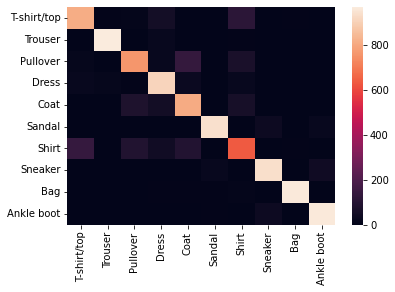

In [ ]:
image = sns.heatmap(cm)
images.append(wandb.Image(image, caption = 'Model 2'))

In [ ]:
with open('model3.pkl', 'rb') as f:
    model3 = pickle.load(f)

In [ ]:
predictions = []
for x in x_test:
  pred = model3.feedforward(x)
  predictions.append(pred)
        
y_pred = [np.argmax(predictions[i]) for i in range(0,len(predictions))]
y_label = [np.argmax(y_test[i]) for i in range(0,len(y_test))]

In [ ]:
print(accuracy_score(y_label, y_pred))

0.874


In [ ]:
cm = pd.DataFrame(confusion_matrix(y_label, y_pred), columns=labels_fashion_mnist, index = labels_fashion_mnist)

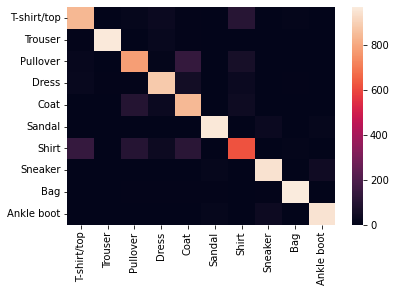

In [ ]:
image = sns.heatmap(cm)
images.append(wandb.Image(image, caption = 'Model 3'))

In [ ]:
wandb.init(entity=entity_name,project=project_name, name="q7_run")
wandb.log({"Confusion_Matrix":images})
wandb.finish()

#Question 8: Comparing with MSE

In [22]:
best_params_1['loss_type'] = 'MSE'
network = NeuralNetwork(**best_params_1)

wandb.init(entity=entity_name,project=project_name, name="mse_run")

print('Training process started with '+network.optimizer+' optimizer.')
for i in range(0, n_epoch_1):
    train_loss,train_acc,test_acc,test_loss = network.epoch(x_train, y_train, x_val, y_val, i)
    log_dict = {"train_loss":train_loss, "train_accuracy":train_acc, "validation_loss":test_loss, "validation_accuracy":test_acc, "epoch":i+1}
    wandb.log(log_dict)

wandb.run.save()
wandb.run.finish()

wandb: Currently logged in as: dhananjayb (clroymustang). Use `wandb login --relogin` to force relogin


Training process started with nadam optimizer.
Epoch 1 completed. Training Loss is 0.4010596692875084, training accuracy is 0.8578703703703704. The test loss is 0.47018222452279507 and the test accuracy is 0.8455.
Epoch 2 completed. Training Loss is 0.5407376554326214, training accuracy is 0.8796111111111111. The test loss is 0.6131737216373971 and the test accuracy is 0.8668333333333333.
Epoch 3 completed. Training Loss is 0.691067156155829, training accuracy is 0.8843148148148148. The test loss is 0.7700227663806325 and the test accuracy is 0.8688333333333333.
Epoch 4 completed. Training Loss is 0.8547500246811254, training accuracy is 0.8901666666666667. The test loss is 0.9367222006394795 and the test accuracy is 0.8763333333333333.
Epoch 5 completed. Training Loss is 1.0199133613069666, training accuracy is 0.8926666666666667. The test loss is 1.102836145910949 and the test accuracy is 0.877.
Epoch 6 completed. Training Loss is 1.1927143091971089, training accuracy is 0.896. The t

wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


Epoch 10 completed. Training Loss is 2.0007476452915522, training accuracy is 0.8839444444444444. The test loss is 2.0882356445787935 and the test accuracy is 0.8681666666666666.


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▅▆▇▇▆█▇▅
train_loss,▁▂▂▃▄▄▅▆▇█
validation_accuracy,▁▅▆▇▇█▇▇▇▆
validation_loss,▁▂▂▃▄▅▅▆▇█
epoch,10
train_accuracy,0.88394
train_loss,2.00075
validation_accuracy,0.86817
validation_loss,2.08824


In [23]:
file_name = 'model1_mse.pkl'
with open(file_name, 'wb') as file:
    pickle.dump(network, file)
    print(f'Object successfully saved to "{file_name}"')

Object successfully saved to "model1_mse.pkl"


In [24]:
best_params_2['loss_type'] = 'MSE'
network = NeuralNetwork(**best_params_2)

wandb.init(entity=entity_name,project=project_name, name="mse_run")

print('Training process started with '+network.optimizer+' optimizer.')
for i in range(0, n_epoch_2):
    train_loss,train_acc,test_acc,test_loss = network.epoch(x_train, y_train, x_val, y_val, i)
    log_dict = {"train_loss":train_loss, "train_accuracy":train_acc, "validation_loss":test_loss, "validation_accuracy":test_acc, "epoch":i+1}
    wandb.log(log_dict)

wandb.run.save()
wandb.run.finish()
file_name = 'model2_mse.pkl'
with open(file_name, 'wb') as file:
    pickle.dump(network, file)
    print(f'Object successfully saved to "{file_name}"')

Training process started with adam optimizer.
Epoch 1 completed. Training Loss is 388.4102148345598, training accuracy is 0.846574074074074. The test loss is 398.0686725515725 and the test accuracy is 0.8435.
Epoch 2 completed. Training Loss is 406.1759186354132, training accuracy is 0.8597777777777778. The test loss is 412.8542450605822 and the test accuracy is 0.8518333333333333.
Epoch 3 completed. Training Loss is 419.702931707343, training accuracy is 0.8675. The test loss is 425.6825543661023 and the test accuracy is 0.8605.
Epoch 4 completed. Training Loss is 432.2194102326166, training accuracy is 0.8752777777777778. The test loss is 437.84074456616327 and the test accuracy is 0.8665.
Epoch 5 completed. Training Loss is 444.3678006316101, training accuracy is 0.8793703703703704. The test loss is 450.1842431083999 and the test accuracy is 0.8686666666666667.
Epoch 6 completed. Training Loss is 457.31011579641495, training accuracy is 0.8821296296296296. The test loss is 463.66296

epoch,▁▂▃▄▅▅▆▇█
train_accuracy,▁▄▅▇▇██▇█
train_loss,▁▂▃▄▄▅▆▇█
validation_accuracy,▁▃▅▇███▇█
validation_loss,▁▂▃▃▄▅▆▇█
epoch,9
train_accuracy,0.88161
train_loss,503.04725
validation_accuracy,0.86917
validation_loss,510.62432


Object successfully saved to "model2_mse.pkl"


In [25]:
best_params_3['loss_type'] = 'MSE'
network = NeuralNetwork(**best_params_3)

wandb.init(entity=entity_name,project=project_name, name="mse_run")

print('Training process started with '+network.optimizer+' optimizer.')
for i in range(0, n_epoch_3):
    train_loss,train_acc,test_acc,test_loss = network.epoch(x_train, y_train, x_val, y_val, i)
    log_dict = {"train_loss":train_loss, "train_accuracy":train_acc, "validation_loss":test_loss, "validation_accuracy":test_acc, "epoch":i+1}
    wandb.log(log_dict)

wandb.run.save()
wandb.run.finish()
file_name = 'model3_mse.pkl'
with open(file_name, 'wb') as file:
    pickle.dump(network, file)
    print(f'Object successfully saved to "{file_name}"')

Training process started with nadam optimizer.


<ipython-input-8-bc3f486ea7f2>:120: RuntimeWarning: overflow encountered in exp
  out = [np.exp(x) for x in output]
<ipython-input-8-bc3f486ea7f2>:121: RuntimeWarning: invalid value encountered in true_divide
  out = out/np.sum((out))


Epoch 1 completed. Training Loss is nan, training accuracy is 0.10048148148148148. The test loss is nan and the test accuracy is 0.09566666666666666.
Epoch 2 completed. Training Loss is nan, training accuracy is 0.10048148148148148. The test loss is nan and the test accuracy is 0.09566666666666666.
Epoch 3 completed. Training Loss is nan, training accuracy is 0.10048148148148148. The test loss is nan and the test accuracy is 0.09566666666666666.
Epoch 4 completed. Training Loss is nan, training accuracy is 0.10048148148148148. The test loss is nan and the test accuracy is 0.09566666666666666.


epoch,▁▃▆█
train_accuracy,▁▁▁▁
validation_accuracy,▁▁▁▁
epoch,4
train_accuracy,0.10048
train_loss,nan
validation_accuracy,0.09567
validation_loss,nan


Object successfully saved to "model3_mse.pkl"


Now, calculating the test accuracies

In [26]:
with open('model1_mse.pkl', 'rb') as f:
    model = pickle.load(f)

accuracy = model.inference(x_test, y_test, loss_flag = False)
print(accuracy)

0.8528


In [27]:
with open('model2_mse.pkl', 'rb') as f:
    model = pickle.load(f)

accuracy = model.inference(x_test, y_test, loss_flag = False)
print(accuracy)

0.861


In [28]:
with open('model3_mse.pkl', 'rb') as f:
    model = pickle.load(f)

accuracy = model.inference(x_test, y_test, loss_flag = False)
print(accuracy)

0.1


#Question 10: Performance on MNIST

In [10]:
from keras.datasets import mnist

In [11]:
best_params_1 = {
  'n_hidden':3, 'hl_size': 128, 'batch_size':32, 'weight_init':'Xavier', 'activation_fn':'tanh', \
 'optimizer':'nadam', 'lamda':0.0005, 'lr':0.001
}

n_epoch_1 = 10

In [12]:
best_params_2 = {
  'n_hidden':5, 'hl_size': 128, 'batch_size':32, 'weight_init':'Xavier', 'activation_fn':'tanh', \
 'optimizer':'adam', 'lamda':0.5, 'lr':0.0001
}

n_epoch_2 = 9

In [13]:
best_params_3 = {
  'n_hidden':3, 'hl_size': 128, 'batch_size':64, 'weight_init':'Xavier', 'activation_fn':'ReLU', \
 'optimizer':'nadam', 'lamda':0.5, 'lr':0.001
}

n_epoch_3 = 4

In [14]:
(trainX, trainy), (testX, testy) = mnist.load_data()

trainX = trainX/255
testX = testX/255

trainX, valX, trainy, valy = train_test_split(trainX, trainy, test_size=0.1, random_state=40)

#Add code to flatten images
x_train = []
x_test = []
x_val = []
for i in range(0, len(trainX)):
  x_train.append(trainX[i,:,:].flatten())
for i in range(0, len(testX)):
  x_test.append(testX[i,:,:].flatten())
for i in range(0, len(valX)):
  x_val.append(valX[i,:,:].flatten())

y_train = to_categorical(trainy)
y_test = to_categorical(testy)
y_val = to_categorical(valy)

In [ ]:
network = NeuralNetwork(**best_params_1)

wandb.init(entity=entity_name,project=project_name, name="mnist")

print('Training process started with '+network.optimizer+' optimizer.')
for i in range(0, n_epoch_1):
    train_loss,train_acc,test_acc,test_loss = network.epoch(x_train, y_train, x_val, y_val, i)
    log_dict = {"train_loss":train_loss, "train_accuracy":train_acc, "validation_loss":test_loss, "validation_accuracy":test_acc, "epoch":i+1}
    wandb.log(log_dict)

wandb.run.save()
wandb.run.finish()


In [16]:
accuracy = network.inference(x_test, y_test, loss_flag = False)
print(accuracy)

0.9089


In [17]:
network = NeuralNetwork(**best_params_2)

wandb.init(entity=entity_name,project=project_name, name="mnist")

print('Training process started with '+network.optimizer+' optimizer.')
for i in range(0, n_epoch_2):
    train_loss,train_acc,test_acc,test_loss = network.epoch(x_train, y_train, x_val, y_val, i)
    log_dict = {"train_loss":train_loss, "train_accuracy":train_acc, "validation_loss":test_loss, "validation_accuracy":test_acc, "epoch":i+1}
    wandb.log(log_dict)

wandb.run.save()
wandb.run.finish()

accuracy = network.inference(x_test, y_test, loss_flag = False)
print(accuracy)

Training process started with adam optimizer.
Epoch 1 completed. Training Loss is 394.4610840091062, training accuracy is 0.9241666666666667. The test loss is 412.6984869447997 and the test accuracy is 0.9233333333333333.
Epoch 2 completed. Training Loss is 429.6742041281212, training accuracy is 0.9399444444444445. The test loss is 445.3256568049343 and the test accuracy is 0.9395.
Epoch 3 completed. Training Loss is 461.3371847358936, training accuracy is 0.9502037037037037. The test loss is 478.1958147810569 and the test accuracy is 0.9445.
Epoch 4 completed. Training Loss is 497.3292743107647, training accuracy is 0.9554814814814815. The test loss is 517.9740933079646 and the test accuracy is 0.949.
Epoch 5 completed. Training Loss is 541.2993340802642, training accuracy is 0.9610925925925926. The test loss is 566.7266911932867 and the test accuracy is 0.9536666666666667.
Epoch 6 completed. Training Loss is 594.1697378533157, training accuracy is 0.9654814814814815. The test loss i

epoch,▁▂▃▄▅▅▆▇█
train_accuracy,▁▃▅▆▆▇██▂
train_loss,▁▂▂▃▃▄▅▆█
validation_accuracy,▁▄▅▅▆▇▇█▂
validation_loss,▁▁▂▃▃▄▅▆█
epoch,9
train_accuracy,0.93435
train_loss,828.19769
validation_accuracy,0.928
validation_loss,880.61024


0.9282


In [18]:
network = NeuralNetwork(**best_params_3)

wandb.init(entity=entity_name,project=project_name, name="mnist")

print('Training process started with '+network.optimizer+' optimizer.')
for i in range(0, n_epoch_3):
    train_loss,train_acc,test_acc,test_loss = network.epoch(x_train, y_train, x_val, y_val, i)
    log_dict = {"train_loss":train_loss, "train_accuracy":train_acc, "validation_loss":test_loss, "validation_accuracy":test_acc, "epoch":i+1}
    wandb.log(log_dict)

wandb.run.save()
wandb.run.finish()

accuracy = network.inference(x_test, y_test, loss_flag = False)
print(accuracy)

Training process started with nadam optimizer.
Epoch 1 completed. Training Loss is 307.53931456510884, training accuracy is 0.9532962962962963. The test loss is 347.83595211427735 and the test accuracy is 0.9463333333333334.
Epoch 2 completed. Training Loss is 375.99810516210545, training accuracy is 0.969574074074074. The test loss is 403.6359163773243 and the test accuracy is 0.9636666666666667.
Epoch 3 completed. Training Loss is 430.1609596452648, training accuracy is 0.9759629629629629. The test loss is 456.6191501593664 and the test accuracy is 0.967.
Epoch 4 completed. Training Loss is 482.9046989751893, training accuracy is 0.9798888888888889. The test loss is 507.03106463363446 and the test accuracy is 0.9668333333333333.


epoch,▁▃▆█
train_accuracy,▁▅▇█
train_loss,▁▄▆█
validation_accuracy,▁▇██
validation_loss,▁▃▆█
epoch,4
train_accuracy,0.97989
train_loss,482.9047
validation_accuracy,0.96683
validation_loss,507.03106


0.9687
